#### **Sincerity of an Emotion**
Determining the sincerity of an emotion is a complex and nuanced process, as emotions can be expressed in different ways depending on the individual and the situation. The following can help us in determining the sincerity of an emotion:

*1) Looking for consistency*: If someone's emotional expression is consistent with their words and actions, it's more likely to be sincere. For example, if someone expresses happiness and their body language and behavior reflect that emotion, it's more likely to be genuine.

*2) Considering context*: Emotions can be influenced by a range of factors, such as culture, personality, and past experiences. Consider the context in which the emotion is expressed, as well as the person's background and history, to better understand the sincerity of their emotions.

*3) Looking for microexpressions*: Microexpressions are brief, involuntary facial expressions that reveal an individual's true emotions. If someone is trying to hide their emotions, they may still display microexpressions that reveal their true feelings.

*4) Listening to the tone of voice*: The tone of voice can provide clues to the sincerity of an emotion. If someone's voice sounds flat or robotic, it may suggest that they are not being genuine.

Below we have worked upon the third point i.e. **looked for microexpressions** in an image. We started by extracting micro features from the images, as such features can somewhat give us a cue as to the state of the person emotions, such as:

* *Eyebrow position*: When a person is surprised or angry, their eyebrows are typically raised. When they are sad or disappointed, their eyebrows may be lowered.

* *Mouth shape*: The shape of a person's mouth can indicate a range of emotions. For example, a smile may indicate happiness, while a frown may indicate sadness or anger.

* *Wrinkles around the eyes*: The presence of wrinkles around the eyes, also known as crow's feet, can indicate that a person is smiling or happy.

* *Eye openness*: The size of a person's eyes can indicate a range of emotions. For example, when a person is surprised or scared, their eyes may widen. Conversely, when a person is angry, their eyes may narrow.

* *Lip curvature*: The curvature of a person's lips can indicate whether they are smiling or frowning.

* *Nose wrinkles*: The presence of wrinkles on a person's nose can indicate a range of emotions, such as disgust or anger.

* *Jaw tension*: The tension in a person's jaw muscles can provide an indication of their emotional state. For example, a person who is angry or stressed may clench their jaw.

* *Brow furrows*: The degree to which a person's eyebrows are furrowed can indicate their level of stress or anger.

* *Mouth opening*: The degree to which a person's mouth is open can indicate a range of emotions, such as surprise, fear, or happiness.

* *Chin thrust*: The position of a person's chin can indicate their level of confidence or assertiveness.

**PS** : In total we have extracted 18 features and used them in addition to the features extracted from our images.

Furthermore, speech analysis algorithms can be used to detect changes in pitch, tone, and other characteristics that may indicate sincerity or insincerity or explore the context and consistency to further help us in our objective.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import random
import dlib
import h5py
import cv2
import os
import gc
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.image import extract_face_landmarks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import imageio
import imgaug as ia
import imgaug.augmenters as iaa

import tensorflow as tf
from keras import optimizers, regularizers
from keras.models import Sequential, Model
from keras.optimizers import RMSprop,SGD,Adam
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, concatenate
from keras.layers import Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

In [ ]:
# adding the downloaded files to angry train files.

save_dir = '/content/drive/MyDrive/Colab Notebooks/train/Angry'
dir = '/content/drive/MyDrive/Colab Notebooks/Angry'
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Colab Notebooks/haarcascade_frontalface_default.xml')
count = 0

for file in os.listdir(dir):
    path = dir+'/'+file
    img = cv2.imread(path, 0)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)

    for (x,y,w,h) in faces:
        img = img[y:y+h, x:x+w]
        shape = img.shape
        if shape[0] == 0 or shape[1] == 0:
            continue
        else:
            img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_NEAREST)
            os.chdir(save_dir)
            cv2.imwrite(file.split('-')[1]+'.jpg', img)

print(count)

Since project methodology is concerned with angry, happy, sad and neutral, we are focusing on them only

In [3]:
DIR = '/content/drive/MyDrive/Colab Notebooks/train/'
emotions = ['Angry', 'Happy', 'Neutral', 'Sad']
IMG_SIZE = 96

#### **Getting Face Landmarks and using them to extract soft signals to detect emotions**

#### Features Extraction

In [4]:
'''Eye aspect ratio (EAR): The eye aspect ratio is a measure of 
how open or closed a person's eyes are. A lower EAR value can 
indicate that the person's eyes are closed or partially closed, 
which could be a sign of fatigue, boredom, or sadness.'''

import math
def eye_aspect_ratio(eye):
    A = math.dist(eye[1], eye[5])
    B = math.dist(eye[2], eye[4])
    C = math.dist(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

'''Mouth aspect ratio (MAR): The mouth aspect ratio is a measure
of how open or closed a person's mouth is. A lower MAR value can
indicate that the person's mouth is closed or partially closed,
which could be a sign of sadness, anger, or anxiety.'''

def mouth_aspect_ratio(mouth):
    A = math.dist(mouth[13], mouth[19])
    B = math.dist(mouth[14], mouth[18])
    C = math.dist(mouth[15], mouth[17])
    D = math.dist(mouth[12], mouth[16])
    mar = (A + B + C) / (3.0 * D)
    return mar

'''Nose aspect ratio (NAR): The nose aspect ratio is a measure of
the width of a person's nose relative to the distance between their
eyes. A higher NAR value can indicate that the person is 
smiling or feeling happy.'''

def nose_aspect_ratio(nose, landmarks):
    # Define the indexes of the eye landmarks
    LEFT_EYE_START_INDEX = 36
    LEFT_EYE_END_INDEX = 41
    RIGHT_EYE_START_INDEX = 42
    RIGHT_EYE_END_INDEX = 47

    A = math.dist(landmarks[36], landmarks[41])
    B = math.dist(landmarks[42], landmarks[47])
    interocular_distance = (A + B) / 2

    C = math.dist(nose[0], nose[4])
    nar = C / interocular_distance
    return nar

# extract features

def extract_features(landmarks):
    # distance between the corners of the eyes
    eye_dist = landmarks[45][0] - landmarks[36][0]

    # Eyebrow position
    left_eyebrow_position = (landmarks[21][1] + landmarks[22][1]) / 2
    right_eyebrow_position = (landmarks[1][1] + landmarks[18][1]) / 2

    # Angle between the eyebrows
    eyebrow_angle = np.arctan2(landmarks[21][1] - landmarks[17][1], landmarks[22][0] - landmarks[18][0]) * 180 / np.pi

    # Mouth height and width
    mouth_height = landmarks[66][1] - landmarks[62][1]
    mouth_width = landmarks[54][0] - landmarks[48][0]

    # Wrinkles around the eyes
    left_eye_crow_feet = landmarks[41][0] - landmarks[36][0]
    right_eye_crow_feet = landmarks[45][0] - landmarks[42][0]
    
    # Eye openness
    left_eye_height = landmarks[40][1] - landmarks[38][1]
    right_eye_height = landmarks[47][1] - landmarks[43][1]

    # Nose wrinkles
    nose_wrinkles = landmarks[31][1] - landmarks[35][1]

    # Jaw tension
    jaw_tension = landmarks[57][1] - landmarks[8][1]

    # Brow furrows
    brow_furrows = (landmarks[22][1] - landmarks[21][1]) + (landmarks[27][1] - landmarks[24][1])

    # Chin thrust
    chin_thrust = landmarks[8][1] - landmarks[51][1]

    # eye aspect ratio
    left_EAR = eye_aspect_ratio(landmarks[36:42])
    right_EAR = eye_aspect_ratio(landmarks[42:48])

    # mouth aspect ratio
    MAR = mouth_aspect_ratio(landmarks[48:68])

    # node aspect ratio
    NAR = nose_aspect_ratio(landmarks[31:36], landmarks)

    return [eye_dist, left_eyebrow_position, right_eyebrow_position, abs(round(eyebrow_angle, 3)), mouth_height, mouth_width, 
            left_eye_crow_feet, right_eye_crow_feet, left_eye_height, right_eye_height, abs(nose_wrinkles), abs(jaw_tension), 
            brow_furrows, chin_thrust, round(left_EAR,2), round(right_EAR, 3), round(MAR, 3), round(NAR, 3)]

In [5]:
# function to create dataframe for better presentation

def create_dataframe(features):
    images = []
    eye_dist = []
    left_eyebrow_position = []
    right_eyebrow_position = []
    eyebrow_angle = []
    mouth_height = []
    mouth_width = []
    left_eye_crow_feet = []
    right_eye_crow_feet = []
    left_eye_height = []
    right_eye_height = []
    nose_wrinkles = []
    jaw_tension = []
    brow_furrows = []
    chin_thrust = []
    left_EAR = []
    right_EAR = []
    MAR = []
    NAR = []
    labels = []

    for i in range(len(features)):
        # getting images1
        images.append(features[i][0] )

        # getting features
        eye_dist.append(features[i][1][0])
        left_eyebrow_position.append(features[i][1][1])
        right_eyebrow_position.append(features[i][1][2])
        eyebrow_angle.append(features[i][1][3])
        mouth_height.append(features[i][1][4])
        mouth_width.append(features[i][1][5])
        left_eye_crow_feet.append(features[i][1][6])
        right_eye_crow_feet.append(features[i][1][7])
        left_eye_height.append(features[i][1][8])
        right_eye_height.append(features[i][1][9])
        nose_wrinkles.append(features[i][1][10])
        jaw_tension.append(features[i][1][11])
        brow_furrows.append(features[i][1][12])
        chin_thrust.append(features[i][1][13])
        left_EAR.append(features[i][1][14])
        right_EAR.append(features[i][1][15])
        MAR.append(features[i][1][16])
        NAR.append(features[i][1][17])

        # labels
        labels.append(features[i][2])

    df = pd.DataFrame()
    df['eye_dist'] = eye_dist
    df['left_eyebrow_position'] = left_eyebrow_position
    df['right_eyebrow_position'] = right_eyebrow_position
    df['eyebrow_angle'] = eyebrow_angle
    df['mouth_height'] = mouth_height
    df['mouth_width'] = mouth_width
    df['left_eye_crow_feet'] = left_eye_crow_feet
    df['right_eye_crow_feet'] = right_eye_crow_feet
    df['left_eye_height'] = left_eye_height
    df['right_eye_height'] = right_eye_height
    df['nose_wrinkles'] = nose_wrinkles
    df['jaw_tension'] = jaw_tension
    df['brow_furrows'] = brow_furrows
    df['chin_thrust'] = chin_thrust
    df['left_EAR'] = left_EAR
    df['right_EAR'] = right_EAR
    df['MAR'] = MAR
    df['NAR'] = NAR
    df['Images'] = images
    df['Labels'] = labels

    return df

In [ ]:
# import dlib
# import cv2

# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# img = cv2.imread(r'C:\Users\himan\ML\PycharmProjects\openCV\Emotion_Detection\train\happy\Training_87867.jpg', 0)
# print(img.shape)

# # detect the faces
# faces = detector(img)
# print(len(faces))
# # loop over each face
# for face in faces:
#     # get the facial landmarks
#     landmarks = predictor(img, face)
#     print(landmarks.part(0))

# cv2.imshow('image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

I planned on using dlib library for extracting face landamrks, but it was working poorly for my case. 

After which I used mlxtend to extarct landmarks, which makes use of dlib to extract face landmarks in the underlying code.

In [6]:
# getting images, features and labels from our inputs

features = []
count = 0

for emotion in emotions:
    image_dir = DIR+emotion
    print(emotion)
    for file in os.listdir(image_dir):
        path = image_dir+'/'+file 
        #print(path)  
        img = cv2.imread(path, 0)
        img = cv2.resize(img, dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)

        try:
            # detect the faces
            landmarks = extract_face_landmarks(img)
            #print(landmarks.shape)
            features.append([img, extract_features(landmarks), emotions.index(emotion)])

        except:
            count += 1 

Angry


/usr/local/lib/python3.9/dist-packages/mlxtend/image/extract_face_landmarks.py:61: UserWarning: No face detected.
  warnings.warn('No face detected.')


Happy
Neutral
Sad


In [ ]:
# # saving the features file

# import pickle

# with open('features.pkl', 'wb') as f:
#   pickle.dump(features, f)

In [ ]:
# with open('/content/drive/MyDrive/Colab Notebooks/features.pkl', 'rb') as f:
#   features = pickle.load(f)

In [7]:
# creating a dataframe to see all the features we have extracted

df = create_dataframe(features)
df.head()

,eye_dist,left_eyebrow_position,right_eyebrow_position,eyebrow_angle,mouth_height,mouth_width,left_eye_crow_feet,right_eye_crow_feet,left_eye_height,right_eye_height,nose_wrinkles,jaw_tension,brow_furrows,chin_thrust,left_EAR,right_EAR,MAR,NAR,Images,Labels
0,47,28.0,38.0,3.814,6,25,4,14,5,4,0,8,12,24,0.36,0.289,0.254,3.134,"[[177, 177, 122, 122, 39, 39, 56, 56, 29, 29, ...",0
1,53,32.0,38.5,0.000,-1,34,5,16,3,2,2,16,11,22,0.23,0.156,0.022,3.622,"[[74, 74, 114, 114, 142, 142, 135, 135, 125, 1...",0
2,47,33.5,27.0,19.026,6,27,3,14,4,4,4,11,6,23,0.32,0.279,0.241,3.426,"[[167, 167, 156, 156, 150, 150, 141, 141, 163,...",0
3,33,51.5,50.0,16.699,2,18,2,10,2,3,3,5,6,12,0.23,0.250,0.139,3.806,"[[238, 238, 235, 235, 233, 233, 231, 231, 229,...",0
4,33,30.5,34.0,6.116,1,17,4,7,3,3,1,18,9,27,0.26,0.405,0.116,2.735,"[[75, 75, 82, 82, 82, 82, 104, 104, 121, 121, ...",0


In [8]:
df.shape

(18076, 20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18076 entries, 0 to 18075
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   eye_dist                18076 non-null  int32  
 1   left_eyebrow_position   18076 non-null  float64
 2   right_eyebrow_position  18076 non-null  float64
 3   eyebrow_angle           18076 non-null  float64
 4   mouth_height            18076 non-null  int32  
 5   mouth_width             18076 non-null  int32  
 6   left_eye_crow_feet      18076 non-null  int32  
 7   right_eye_crow_feet     18076 non-null  int32  
 8   left_eye_height         18076 non-null  int32  
 9   right_eye_height        18076 non-null  int32  
 10  nose_wrinkles           18076 non-null  int32  
 11  jaw_tension             18076 non-null  int32  
 12  brow_furrows            18076 non-null  int32  
 13  chin_thrust             18076 non-null  int32  
 14  left_EAR                18076 non-null

In [10]:
# sample of what a value in features contain

features[0]

[array([[177, 177, 122, ...,  55,  58,  58],
        [177, 177, 122, ...,  55,  58,  58],
        [119, 119,  50, ...,  44,  46,  46],
        ...,
        [254, 254, 255, ..., 254, 255, 255],
        [255, 255, 254, ..., 255, 255, 255],
        [255, 255, 254, ..., 255, 255, 255]], dtype=uint8),
 [47,
  28.0,
  38.0,
  3.814,
  6,
  25,
  4,
  14,
  5,
  4,
  0,
  8,
  12,
  24,
  0.36,
  0.289,
  0.254,
  3.134],
 0]

In [11]:
# Data Preprocessing

def preprocessing(features, n):
    
    # shuffling the dataset
    random.shuffle(features)

    # assigning labels and features

    X = []
    feature = []
    y = []
    for image, feat, label in features:
        X.append(image)
        feature.append(feat)
        y.append(label)

    # resizing features in accordance with CNN(we have gray images)
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

    # Normalising X and converting labels to categorical features
    X = X.astype('float32')
    X /= 255

    # scaling our features
    scaler = StandardScaler()
    feature = scaler.fit_transform(feature)

    y = np_utils.to_categorical(y,n)

    return X, feature, y

In [12]:
X, feat, y = preprocessing(features, 4)
X.shape, feat.shape, y.shape

((18076, 96, 96, 1), (18076, 18), (18076, 4))

In [13]:
# callbacks

model_name = 'EmotionDetectionFeat.h5'
checkpoint = ModelCheckpoint(model_name,
                            monitor='val_loss',
                            mode='auto',
                            verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)
redudeLR = ReduceLROnPlateau(monitor='val_loss',
                            factor = 0.2,
                            patience=1,
                            verbose=1,
                            min_delta=0.0001)
callbacks = [earlystop, checkpoint, redudeLR]

In [14]:
gc.collect()

91

### Model 1

In [15]:
# let's build our model

# Define the input shapes for the image and feature inputs
image_input_shape = (IMG_SIZE, IMG_SIZE, 1)
feature_input_shape = (18,)

# Define the image input layer
image_input = Input(shape=image_input_shape, name='image_input')

# Define the feature input layer
feature_input = Input(shape=feature_input_shape, name='feature_input')

# Define the CNN for image processing
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',
                    input_shape=image_input_shape))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

            
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))


cnn.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(64, activation = 'relu'))
    

# Process the image input with the CNN
image_features = cnn(image_input)

# Concatenate the image features with the extracted features
concatenated_features = concatenate([image_features, feature_input])

# Define the output layer
output = Dense(4, activation='softmax', name='output')(concatenated_features)

# Define the model
model = Model(inputs=[image_input, feature_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X, feat], y, epochs=20, validation_split=0.25, callbacks=callbacks)

Epoch 1/20
424/424 [==============================] - ETA: 0s - loss: 1.2301 - accuracy: 0.4469
Epoch 1: saving model to EmotionDetectionFeat.h5
424/424 [==============================] - 21s 20ms/step - loss: 1.2301 - accuracy: 0.4469 - val_loss: 1.0983 - val_accuracy: 0.5479 - lr: 0.0010
Epoch 2/20
422/424 [============================>.] - ETA: 0s - loss: 1.0059 - accuracy: 0.5699
Epoch 2: saving model to EmotionDetectionFeat.h5
424/424 [==============================] - 7s 17ms/step - loss: 1.0058 - accuracy: 0.5697 - val_loss: 0.9791 - val_accuracy: 0.5970 - lr: 0.0010
Epoch 3/20
421/424 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.6109
Epoch 3: saving model to EmotionDetectionFeat.h5
424/424 [==============================] - 7s 17ms/step - loss: 0.9222 - accuracy: 0.6107 - val_loss: 0.9766 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 4/20
424/424 [==============================] - ETA: 0s - loss: 0.8728 - accuracy: 0.6334
Epoch 4: saving model to EmotionD

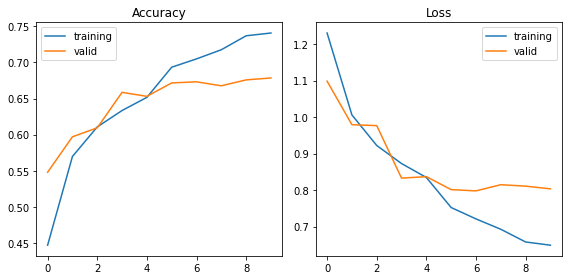

In [16]:
def plotting(history):

  plt.figure(figsize=(8,4))
  
  plt.subplot(1, 2, 1)
  sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='training')
  sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
  plt.title('Accuracy')

  plt.subplot(1, 2, 2)
  sns.lineplot(x=history.epoch, y=history.history['loss'], label='training')
  sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
  plt.title('Loss')

  plt.tight_layout()
  plt.show()

plotting(history)

In [17]:
gc.collect()

2570

### Model 2

In [18]:
cnn2 = Sequential()
cnn2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=image_input_shape))
cnn2.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.25))

cnn2.add(Conv2D(128,(5,5), padding='same', activation='relu'))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.25))
    
cnn2.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.25))

cnn2.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
cnn2.add(BatchNormalization())
cnn2.add(MaxPooling2D(pool_size=(2, 2)))
cnn2.add(Dropout(0.25))

cnn2.add(Flatten()) 
cnn2.add(Dense(256,activation = 'relu'))
cnn2.add(BatchNormalization())
cnn2.add(Dropout(0.25))
    
cnn2.add(Dense(64,activation = 'relu'))
cnn2.add(BatchNormalization())
cnn2.add(Dropout(0.25))


# Process the image input with the CNN
image_features = cnn(image_input)

# Concatenate the image features with the extracted features
concatenated_features = concatenate([image_features, feature_input])

# Define the output layer
output = Dense(4, activation='softmax', name='output')(concatenated_features)

# Define the model
model2 = Model(inputs=[image_input, feature_input], outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit([X, feat], y, epochs=20, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
452/452 [==============================] - ETA: 0s - loss: 0.9208 - accuracy: 0.6098
Epoch 1: saving model to EmotionDetectionFeat.h5
452/452 [==============================] - 10s 18ms/step - loss: 0.9208 - accuracy: 0.6098 - val_loss: 0.8763 - val_accuracy: 0.6397 - lr: 0.0010
Epoch 2/20
450/452 [============================>.] - ETA: 0s - loss: 0.7776 - accuracy: 0.6860
Epoch 2: saving model to EmotionDetectionFeat.h5
452/452 [==============================] - 7s 16ms/step - loss: 0.7777 - accuracy: 0.6862 - val_loss: 0.8135 - val_accuracy: 0.6574 - lr: 0.0010
Epoch 3/20
451/452 [============================>.] - ETA: 0s - loss: 0.7265 - accuracy: 0.7045
Epoch 3: saving model to EmotionDetectionFeat.h5

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
452/452 [==============================] - 7s 16ms/step - loss: 0.7264 - accuracy: 0.7045 - val_loss: 0.8537 - val_accuracy: 0.6485 - lr: 0.0010
Epoch 4/20
449/452 [============================>.]

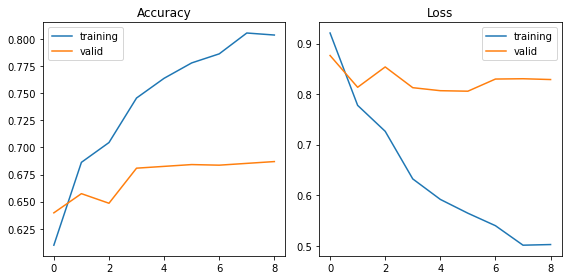

In [19]:
plotting(history2)

* The second model is has got more layers and is bigger, it is overfitting like crazy. Let's go with a more simpler model i.e our first model and try to augment our data to reduce the overfitting.

#### Data Augmentation

In [20]:
# flipping horizontally and vertically
def flipping(img):
    # horizontal
    hflip = iaa.Fliplr(p=1.0)
    imgH = hflip.augment_image(img)

    # vertical
    vflip = iaa.Flipud(p=1.0)
    imgV = vflip.augment_image(img)

    return imgH, imgV

# rotating by 45 and 90
def rotation(img):
    rot1 = iaa.Rotate((-45, 45))
    img1 = rot1.augment_image(img)

    rot2 = aug = iaa.Rotate((-90, 90))
    img2 = rot2.augment_image(img)

    return img1, img2

# adding some noise i.e. blurring our image
def noise(img):
    noise=iaa.AdditiveGaussianNoise(10,10)
    input_noise=noise.augment_image(img)

    return input_noise

In [ ]:
# adding augmented images using above function and adding to our training data

count = 0
features_aug = features.copy()
for i in range(0, len(features), 1):
  img = features[i][0]

  imgH, imgV = flipping(img)
  img45, img90 = rotation(img)
  noisee = noise(img)

  augmented = [imgH, imgV, img45, img90, noisee]
  for aug in augmented:
    try:
      # detect the faces
      landmarks = extract_face_landmarks(aug)
      print(landmarks.shape)
      features_aug.append([aug, extract_features(landmarks), features[i][2]])

    except:
      count += 1

Can't augment my data here, memory seems to run out and the session gets crashed. I'm gonna load the features list from the pickle file.

In [21]:
with open('/content/drive/MyDrive/Colab Notebooks/featuresAug96.pkl', 'rb') as f:
  features = pickle.load(f)

X, feat, y = preprocessing(features, 4)
X.shape, feat.shape, y.shape

((73149, 96, 96, 1), (73149, 18), (73149, 4))

In [22]:
gc.collect()

7958

### Model 3
Let's train the first model wit few minor changes on our augmneted dataset.

In [23]:
# let's build our model

# Define the input shapes for the image and feature inputs
image_input_shape = (IMG_SIZE, IMG_SIZE, 1)
feature_input_shape = (18,)

# Define the image input layer
image_input = Input(shape=image_input_shape, name='image_input')

# Define the feature input layer
feature_input = Input(shape=feature_input_shape, name='feature_input')

# Define the CNN for image processing
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same',
                    input_shape=image_input_shape))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2)))

cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))


cnn.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(128, activation = 'relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(64, activation = 'relu'))
    

# Process the image input with the CNN
image_features = cnn(image_input)

# Concatenate the image features with the extracted features
concatenated_features = concatenate([image_features, feature_input])

# Define the output layer
output = Dense(4, activation='softmax', name='output')(concatenated_features)

# Define the model
model = Model(inputs=[image_input, feature_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X, feat], y, epochs=20, validation_split=0.25, callbacks=callbacks)

Epoch 1/20
1715/1715 [==============================] - ETA: 0s - loss: 1.0478 - accuracy: 0.5479
Epoch 1: saving model to EmotionDetectionFeat.h5
1715/1715 [==============================] - 35s 19ms/step - loss: 1.0478 - accuracy: 0.5479 - val_loss: 0.8935 - val_accuracy: 0.6252 - lr: 0.0010
Epoch 2/20
1714/1715 [============================>.] - ETA: 0s - loss: 0.8658 - accuracy: 0.6384
Epoch 2: saving model to EmotionDetectionFeat.h5
1715/1715 [==============================] - 30s 17ms/step - loss: 0.8657 - accuracy: 0.6384 - val_loss: 0.8252 - val_accuracy: 0.6566 - lr: 0.0010
Epoch 3/20
1714/1715 [============================>.] - ETA: 0s - loss: 0.8075 - accuracy: 0.6670
Epoch 3: saving model to EmotionDetectionFeat.h5
1715/1715 [==============================] - 34s 20ms/step - loss: 0.8076 - accuracy: 0.6670 - val_loss: 0.8006 - val_accuracy: 0.6660 - lr: 0.0010
Epoch 4/20
1713/1715 [============================>.] - ETA: 0s - loss: 0.7673 - accuracy: 0.6881
Epoch 4: saving m

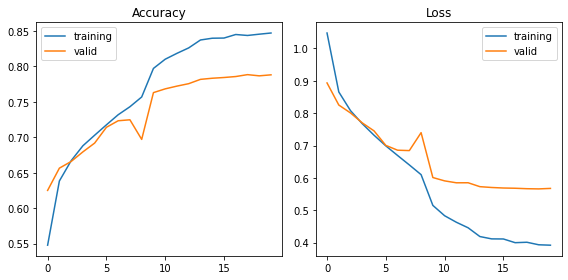

In [24]:
plotting(history)

### **Conclusion**

* The model got dynamic which the soft features that we extracted from the images.
* To start with the available FER is not good, with help better data collection can makes this model do wonders in deployment.
* Not able to train this model with images of higher dimension because of computational and storage constraint is also a bit hindrance.

Inspite of all this, with the 18 features extracted from an image our model is definitely working better and more biased towards the aim of finding whether the emotion is real or not. With the soft features it takes into account, it is more susceptible to miniscule changes.

* Furthermore, 

  1) We can move towards **body postures** and the information it conveys and, 

  2) Parsing through a person's speech via **speech analysis** algorithms that can detect changes in pitch, tone, and other characteristics that may indicate sincerity or insincerity.